# Fourier integration evidence calculation


In [141]:
import time, sys, os
import numpy as np
from tqdm.auto import tqdm
import shutil
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import bilby
import logging
np.random.seed(42)

logging.getLogger('bilby').setLevel(logging.CRITICAL)

# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 20})

## Example 1: Linear regression
 We first consider a simple linear regression model with a Gaussian likelihood. We compute the evidence for the model first with nested sampling, and then with the fourier integration method.

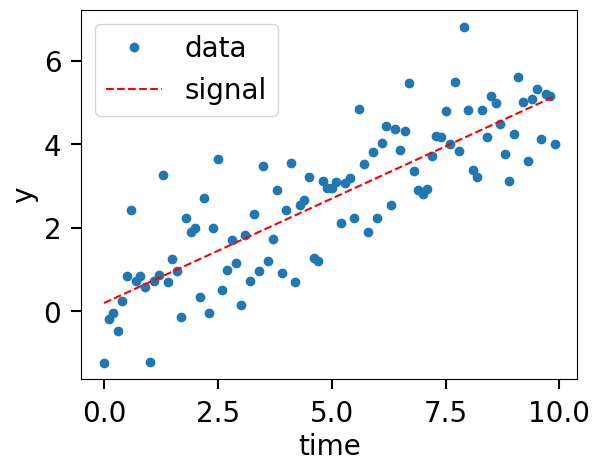

In [19]:
# First, we define our "signal model", in this case a simple linear function
def model(time, m, c):
    return time * m + c


# Now we define the injection parameters which we make simulated data with
injection_parameters = dict(m=0.5, c=0.2)

sampling_frequency = 10
time_duration = 10
time = np.arange(0, time_duration, 1 / sampling_frequency)
N = len(time)
sigma = np.random.normal(1, 0.01, N)
data = model(time, **injection_parameters) + np.random.normal(0, sigma, N)

# We quickly plot the data to check it looks sensible
fig, ax = plt.subplots()
ax.plot(time, data, "o", label="data")
ax.plot(time, model(time, **injection_parameters), "--r", label="signal")
ax.set_xlabel("time")
ax.set_ylabel("y")
ax.legend();


In [115]:

likelihood = bilby.likelihood.GaussianLikelihood(time, data, model, sigma)

priors = bilby.core.prior.PriorDict(dict(
    m = bilby.core.prior.Uniform(0, 5, "m"),
    c =  bilby.core.prior.Uniform(-2, 2, "c")
))

outdir, label = 'out', 'line'
if os.path.exists(outdir):
    shutil.rmtree(outdir)
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=1500,
    outdir=outdir,
    label=label,
    injection_parameters=injection_parameters,    
)

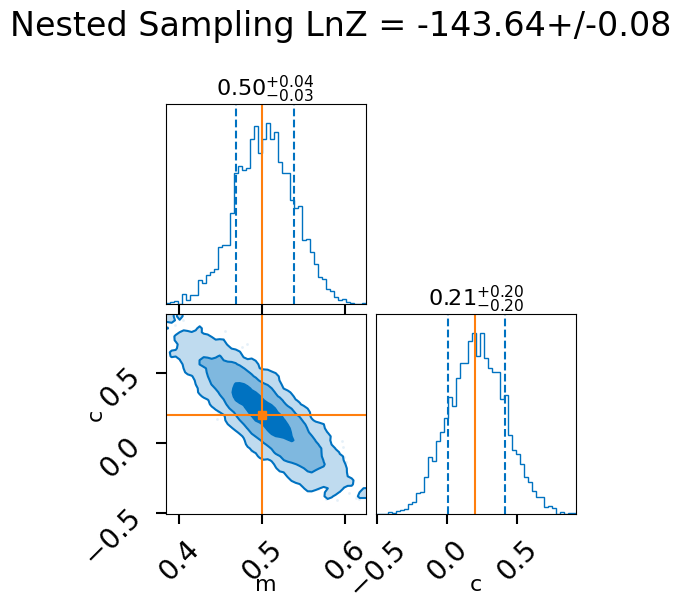

In [116]:
# Finally plot a corner plot: all outputs are stored in outdir
fig = result.plot_corner()
fig.suptitle(f"Nested Sampling LnZ = {result.log_evidence:.2f}+/-{result.log_evidence_err:.2f}", y=1.1);
fig

In [24]:
result.posterior

,m,c,log_likelihood,log_prior
0,0.601205,-0.308000,-147.532088,-2.995732
1,0.554247,-0.219954,-146.830462,-2.995732
2,0.508855,-0.050262,-146.746693,-2.995732
3,0.509460,0.601209,-146.739830,-2.995732
4,0.464210,0.806031,-146.083564,-2.995732
...,...,...,...,...
626,0.484325,0.384934,-141.151069,-2.995732
627,0.490389,0.368775,-141.150614,-2.995732
628,0.487097,0.392140,-141.144533,-2.995732
629,0.484288,0.405462,-141.143861,-2.995732


In [193]:
import numpy as np
import bilby
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


def ln_posterior_approx_for_sample(posterior_samples, ref_parm, r):
    diff_from_ref = posterior_samples - ref_parm
    sin_diff = np.sin(r * diff_from_ref)

    sin_diff_divided_diff = sin_diff / diff_from_ref
    
    res_prod = np.prod(sin_diff_divided_diff, axis=1)
    sum_res = np.sum(res_prod)

    # log_terms = np.log(sin_diff / diff_from_ref)
    # max_val = log_terms.max(axis=1)
    # res_2 = max_val + np.log(np.sum(np.exp(log_terms - max_val[:, np.newaxis]), axis=1))

    # TODO: Getting lots of nans! 
    
#     if np.isnan(sum_res):
#         print(f"NAN! {ref_param}, r={r}")
    
    n_samp, n_dim = posterior_samples.shape
    const = 1 / (n_samp * np.power(np.pi, n_dim))
    return np.log(sum_res * const)


def fi_ln_evidence(posterior_samples, ref_parm, r, reference_lnprior, reference_lnlikelihood):
    approx_ln_post = ln_posterior_approx_for_sample(posterior_samples, ref_parm, r)
    return reference_lnprior + reference_lnlikelihood - approx_ln_post


def get_refernce_lnprior_lnlikelihood(prior, likelihood, ref_parm):
    likelihood.parameters.update(ref_parm)
    lnlike = likelihood.log_likelihood()
    lnprior = prior.ln_prob(ref_parm)
    return lnprior, lnlike


def plot_fi_evidence_results(result, priors, likelihood, ref_parms=[]):
    r_vals = np.geomspace(1e-2, 1e6, 2000)

    sampling_lnz_up = result.log_evidence + result.log_evidence_err
    sampling_lnz_low = result.log_evidence - result.log_evidence_err

    # PLOT Nested Sampling LnZ
    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    ax.fill_between(
        x=r_vals, y1=sampling_lnz_up, y2=sampling_lnz_low,
        color='tab:blue', interpolate=True, alpha=.5, label="Nested Samp. LnZ"
    )
    ax.set_xlim(min(r_vals), max(r_vals))
    ax.set_xlabel(r"FI $R$")
    ax.set_ylabel(r"$\ln{\mathcal{Z}}$")
    ax.set_xscale('log')

    if len(ref_parms) == 0:
        ref_parms = [result.injection_parameters]

    for i, ref_parm in tqdm(enumerate(ref_parms)):
        ref_parm = {k: ref_parm[k] for k in result.search_parameter_keys}
        ref_lnpri, ref_lnl = get_refernce_lnprior_lnlikelihood(priors, likelihood, ref_parm)

        fi_kwargs = dict(
            posterior_samples=result.posterior[result.search_parameter_keys].values,
            ref_parm=np.array([*ref_parm.values()]),
            reference_lnprior=ref_lnpri,
            reference_lnlikelihood=ref_lnl,
        )
        ln_evidences = [fi_ln_evidence(**fi_kwargs, r=ri) for ri in r_vals]
        if i == 0:
            ax.plot(r_vals, ln_evidences, label="FI LnZ", color="tab:green", alpha=0.70)
        else:
            ax.plot(r_vals, ln_evidences, color="tab:green", alpha=0.70)

    ax.legend(loc=(1.1, 0.8), frameon=False)
    plt.tight_layout()
    return fig



In [194]:

ref_param = dict(m=0.49, c=0.37)


fi_lnz_test = fi_ln_evidence(
    posterior_samples=result.posterior[['m','c']].values,
    ref_parm=np.array([*ref_param.values()]),
    r=41,
    reference_lnprior=ref_lnpri,
    reference_lnlikelihood=ref_lnl,
)
print(f"Test FI LnZ (R=100) = {fi_lnz_test:.2f}")

Test FI LnZ (R=100) = -142.69


In [195]:

fi_lnz_test = fi_ln_evidence(
    posterior_samples=result.posterior[['m','c']].values,
    ref_parm=np.array([*injection_parameters.values()]),
    r=100,
    reference_lnprior=ref_lnpri,
    reference_lnlikelihood=ref_lnl,
)
print(f"Test FI LnZ (R=100) = {fi_lnz_test:.2f}")

Test FI LnZ (R=100) = -143.55


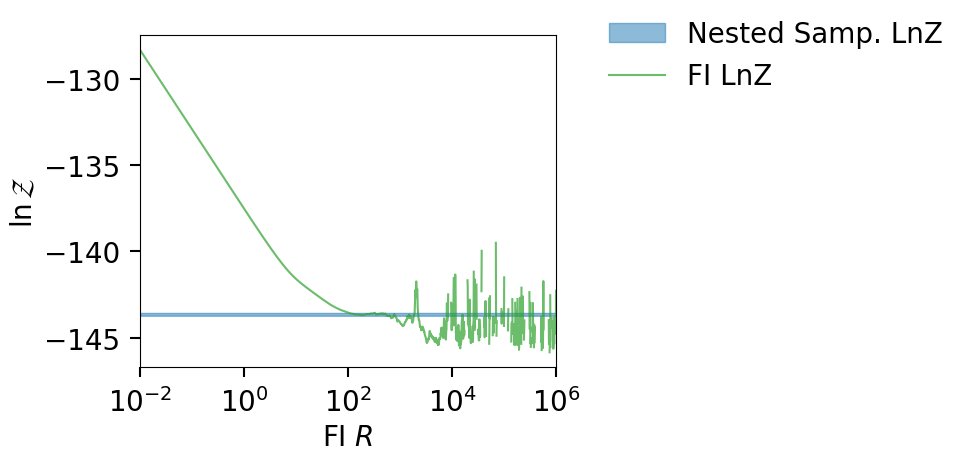

In [196]:
fig = plot_fi_evidence_results(result, priors, likelihood)
fig.tight_layout()

In [197]:
#fig = plot_fi_evidence_results(result, priors, likelihood, result.posterior.sample(10).to_dict('records'))